In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3

In [31]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1) ResNet 기본 블록 구성하기
- 이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 
- 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

- ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 
- 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. 
- ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

# 2) ResNet-34, ResNet-50 Complete Model
- VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. 
- ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

In [4]:
def resnet_basic_block(input_tensor, filters, stride=1):
    # ResNet-34에서 사용하는 기본 블록입니다. 
    # 두 개의 3x3 컨볼루션 레이어로 구성되며, 입력 텐서와 출력 텐서를 더해 skip connection을 형성합니다.
    """
    ResNet Basic Block (Used in ResNet-34)
    - input_tensor: 입력 텐서
    - filters: 출력 채널 수
    - stride: stride 값 (기본값 1)
    """
    # 첫 번째 3x3 컨볼루션 레이어
    x = keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = keras.layers.BatchNormalization()(x)  # 배치 정규화를 통해 학습 안정화
    x = keras.layers.ReLU()(x)  # ReLU 활성화 함수

    # 두 번째 3x3 컨볼루션 레이어
    x = keras.layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)  # 배치 정규화

    # Skip connection 적용 (stride나 채널 수가 맞지 않는 경우 조정)
    if stride != 1 or input_tensor.shape[-1] != filters:
        input_tensor = keras.layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)
        input_tensor = keras.layers.BatchNormalization()(input_tensor)

    # 원본 입력과 변형된 입력을 더한 후 ReLU 적용
    x = keras.layers.add([x, input_tensor])
    x = keras.layers.ReLU()(x)
    return x

In [5]:
def resnet_bottleneck_block(input_tensor, filters, stride=1):
    # ResNet-50에서 사용하는 Bottleneck 블록입니다. 
    # 1x1, 3x3, 1x1 컨볼루션 레이어로 구성되며, 첫 번째 1x1 컨볼루션으로 차원을 줄이고, 마지막 1x1 컨볼루션으로 차원을 복원합니다.
    """
    ResNet Bottleneck Block (Used in ResNet-50)
    - input_tensor: 입력 텐서
    - filters: 중간 레이어에서 사용할 채널 수
    - stride: stride 값 (기본값 1)
    """
    # 첫 번째 1x1 컨볼루션 레이어 (차원 축소)
    x = keras.layers.Conv2D(filters, (1, 1), strides=1, padding='same')(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 두 번째 3x3 컨볼루션 레이어 (중간 처리)
    x = keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 세 번째 1x1 컨볼루션 레이어 (차원 복원)
    x = keras.layers.Conv2D(filters * 4, (1, 1), strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)

    # Skip connection 적용 (stride나 채널 수가 맞지 않는 경우 조정)
    if stride != 1 or input_tensor.shape[-1] != filters * 4:
        input_tensor = keras.layers.Conv2D(filters * 4, (1, 1), strides=stride, padding='same')(input_tensor)
        input_tensor = keras.layers.BatchNormalization()(input_tensor)

    # 원본 입력과 변형된 입력을 더한 후 ReLU 적용
    x = keras.layers.add([x, input_tensor])
    x = keras.layers.ReLU()(x)
    return x

In [6]:
def build_resnet(input_shape=(32, 32, 3), is_50=False, num_classes=10):
    # 전체 ResNet 모델을 생성하는 함수입니다. 
    # 버전에 따라 ResNet-34 또는 ResNet-50을 선택하여 기본 블록을 구성합니다.
    # 각 블록 내에서 첫 레이어는 stride=2로 설정하여 다운샘플링합니다.
    # 마지막에 평균 풀링과 FC 레이어를 추가하여 클래스에 대한 확률을 출력합니다.
    """
    ResNet 모델 생성 함수 (ResNet-34 및 ResNet-50을 위한 설정 포함)
    - input_shape: 입력 이미지의 크기
    - num_classes: 출력 클래스 수
    - version: 'resnet34' 또는 'resnet50' 중 선택
    """
    # 입력 레이어 생성
    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', name='conv1')(input_layer)
    x = keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = keras.layers.Activation('relu', name='conv1_relu')(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same', name='max_pool')(x)

    if is_50:
        # Bottleneck 구조
        block_fn = resnet_bottleneck_block
        layers = [3, 4, 6, 3]
    else:
        # Basic Block 구조
        block_fn = resnet_basic_block
        layers = [3, 4, 6, 3]

    filters = [64, 128, 256, 512]
    for stage, num_blocks in enumerate(layers):
        for block in range(num_blocks):
            stride = 2 if block == 0 and stage != 0 else 1
            x = block_fn(x, filters[stage], stride=stride)

    x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
    output_layer = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer, name=f"resnet{'50' if is_50 else '34'}")
    return model

In [7]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [8]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, 16, 16, 64)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

# 3) 일반 네트워크(plain network) 만들기
## 블록 코드 수정하기
- 우리는 앞에서 ResNet 모델을 구현했습니다. 
- ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다.
- 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

In [9]:
def plain_basic_block(input_tensor, filters, stride=1):
    """
    Plain Network Basic Block (ResNet-34)
    - input_tensor: 입력 텐서
    - filters: 출력 채널 수
    - stride: stride 값 (기본값 1)
    """
    # 첫 번째 3x3 컨볼루션 레이어
    x = keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 두 번째 3x3 컨볼루션 레이어
    x = keras.layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)  # Skip connection 없이 그대로 진행

    return x

In [10]:
def plain_bottleneck_block(input_tensor, filters, stride=1):
    """
    Plain Network Bottleneck Block (ResNet-50)
    - input_tensor: 입력 텐서
    - filters: 중간 레이어에서 사용할 채널 수
    - stride: stride 값 (기본값 1)
    """
    # 첫 번째 1x1 컨볼루션 레이어 (차원 축소)
    x = keras.layers.Conv2D(filters, (1, 1), strides=1, padding='same')(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 두 번째 3x3 컨볼루션 레이어 (중간 처리)
    x = keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # 세 번째 1x1 컨볼루션 레이어 (차원 복원)
    x = keras.layers.Conv2D(filters * 4, (1, 1), strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)  # Skip connection 없이 그대로 진행

    return x

In [11]:
# Basic Block (ResNet-34용, skip connection 포함/미포함 모두 가능)
def basic_block(input_tensor, filters, stride=1, use_plain=False):
    x = keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    if not use_plain:  # Skip connection 포함 시
        if stride != 1 or input_tensor.shape[-1] != filters:
            input_tensor = keras.layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(input_tensor)
            input_tensor = keras.layers.BatchNormalization()(input_tensor)
        x = keras.layers.add([x, input_tensor])
        
    x = keras.layers.ReLU()(x)
    return x

In [12]:
# Bottleneck Block (ResNet-50용, skip connection 포함/미포함 모두 가능)
def bottleneck_block(input_tensor, filters, stride=1, use_plain=False):
    x = keras.layers.Conv2D(filters, (1, 1), strides=1, padding='same')(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    
    x = keras.layers.Conv2D(filters * 4, (1, 1), strides=1, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    
    if not use_plain:  # Skip connection 포함 시
        if stride != 1 or input_tensor.shape[-1] != filters * 4:
            input_tensor = keras.layers.Conv2D(filters * 4, (1, 1), strides=stride, padding='same')(input_tensor)
            input_tensor = keras.layers.BatchNormalization()(input_tensor)
        x = keras.layers.add([x, input_tensor])
        
    x = keras.layers.ReLU()(x)
    return x

In [13]:
# PlainNet 및 ResNet 네트워크 빌드 함수
def build_plainnet(input_shape=(224, 224, 3), is_50=False, num_classes=1000, use_plain=False):
    """
    PlainNet 및 ResNet 모델 생성 함수
    - input_shape: 입력 이미지의 크기
    - is_50: True면 ResNet-50 또는 PlainNet-50, False면 ResNet-34 또는 PlainNet-34
    - num_classes: 출력 클래스 수
    - use_plain: True면 PlainNet, False면 ResNet
    """
    input_layer = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(64, (7, 7), strides=2, padding='same', name='conv1')(input_layer)
    x = keras.layers.BatchNormalization(name='bn_conv1')(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    if is_50:
        block_fn = bottleneck_block
        layers = [3, 4, 6, 3]  # ResNet-50 또는 PlainNet-50의 블록 구성
        filters = [64, 128, 256, 512]
    else:
        block_fn = basic_block
        layers = [3, 4, 6, 3]  # ResNet-34 또는 PlainNet-34의 블록 구성
        filters = [64, 128, 256, 512]

    for stage, num_blocks in enumerate(layers):
        for block in range(num_blocks):
            stride = 2 if block == 0 and stage != 0 else 1  # 각 블록의 첫 번째 레이어에서만 다운샘플링
            x = block_fn(x, filters[stage], stride=stride, use_plain=use_plain)

    x = keras.layers.GlobalAveragePooling2D()(x)
    output_layer = keras.layers.Dense(num_classes, activation='softmax')(x)

    model_name = f"{'plainnet' if use_plain else 'resnet'}{'50' if is_50 else '34'}"
    model = keras.Model(inputs=input_layer, outputs=output_layer, name=model_name)
    return model

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
- ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다.
- 그리고 결과를 비교해 봅시다! 
- ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다.
- 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요.
- 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다.
- 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

## 1. 데이터셋 로딩 및 전처리
- TensorFlow Datasets 라이브러리를 사용하여 cats_vs_dogs 데이터셋을 로딩하고, 224x224 픽셀로 변환합니다.

In [14]:
# 다운로드 URL을 수정
setattr(tfds.image_classification.cats_vs_dogs, '_URL', "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

# 데이터셋 전처리 함수
def preprocess_data(image, label):
    image = tf.image.resize(image, (224, 224))  # 이미지 크기 조정
    image = tf.cast(image, tf.float32) / 255.0  # 정규화
    label = tf.cast(label, tf.int32)
    return image, label

# 데이터셋 로딩 및 전처리
batch_size = 32
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'],
                                         as_supervised=True, with_info=True)

# 전처리 적용 및 배치 생성
ds_train = ds_train.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_data).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## 2. 모델 생성 및 컴파일
- build_plainnet 함수를 이용하여 ResNet-34와 PlainNet-34, ResNet-50과 PlainNet-50 모델을 생성합니다. 

In [23]:
# ResNet-34및 PlainNet-34 모델 생성
resnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False, num_classes=2, use_plain=False)
plainnet_34 = build_plainnet(input_shape=(224, 224, 3), is_50=False, num_classes=2, use_plain=True)

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

resnet_34.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plainnet_34.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [24]:
# ResNet-50 및 PlainNet-50 모델 생성
resnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True, num_classes=2, use_plain=False)
plainnet_50 = build_plainnet(input_shape=(224, 224, 3), is_50=True, num_classes=2, use_plain=True)

# 모델 컴파일
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ['accuracy']

resnet_50.compile(optimizer=optimizer, loss=loss, metrics=metrics)
plainnet_50.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## 3. 모델 학습
- ResNet-34과 PlainNet-34, ResNet-50과 PlainNet-50 모델을 각각 학습합니다

In [27]:
# 모델 학습 (ResNet-34)
history_resnet = resnet_34.fit(ds_train, validation_data=ds_test, epochs=15)

# 모델 학습 (PlainNet-34)
history_plainnet = plainnet_34.fit(ds_train, validation_data=ds_test, epochs=15)

Epoch 1/15
195/582 [=========>....................] - ETA: 1:08 - loss: 0.6735 - accuracy: 0.6077

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:02 - loss: 0.6710 - accuracy: 0.6105

237/582 [===========>..................] - ETA: 1:01 - loss: 0.6703 - accuracy: 0.6114

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.6651 - accuracy: 0.6142

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6447 - accuracy: 0.6351

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.6438 - accuracy: 0.6363

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.6423 - accuracy: 0.6371

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6411 - accuracy: 0.6392

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6414 - accuracy: 0.6388

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.6387

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 195ms/step - loss: 0.6415 - accuracy: 0.6387 - val_loss: 6.0960 - val_accuracy: 0.5138
Epoch 2/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.5966 - accuracy: 0.6832

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.5952 - accuracy: 0.6857

237/582 [===========>..................] - ETA: 1:01 - loss: 0.5959 - accuracy: 0.6843

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.5907 - accuracy: 0.6902

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.5752 - accuracy: 0.7039

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.5753 - accuracy: 0.7040

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.5732 - accuracy: 0.7056

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.5715 - accuracy: 0.7071

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.5716 - accuracy: 0.7069

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.7069

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 114s 196ms/step - loss: 0.5714 - accuracy: 0.7069 - val_loss: 0.8399 - val_accuracy: 0.6451
Epoch 3/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.5338 - accuracy: 0.7356

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.5287 - accuracy: 0.7387

237/582 [===========>..................] - ETA: 1:01 - loss: 0.5301 - accuracy: 0.7364

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.5271 - accuracy: 0.7388

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.5121 - accuracy: 0.7499

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.5118 - accuracy: 0.7504

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.5106 - accuracy: 0.7513

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.5090 - accuracy: 0.7528

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.5091 - accuracy: 0.7525

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.7517

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 193ms/step - loss: 0.5094 - accuracy: 0.7517 - val_loss: 0.5937 - val_accuracy: 0.6806
Epoch 4/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.4652 - accuracy: 0.7837

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.4601 - accuracy: 0.7858

237/582 [===========>..................] - ETA: 1:01 - loss: 0.4618 - accuracy: 0.7840

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.4564 - accuracy: 0.7887

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.4417 - accuracy: 0.7964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.4411 - accuracy: 0.7960

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.4402 - accuracy: 0.7962

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.4388 - accuracy: 0.7972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.4386 - accuracy: 0.7971

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.7970

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.4386 - accuracy: 0.7970 - val_loss: 1.4554 - val_accuracy: 0.5918
Epoch 5/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.3768 - accuracy: 0.8258

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.3729 - accuracy: 0.8292

237/582 [===========>..................] - ETA: 1:02 - loss: 0.3730 - accuracy: 0.8287

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.3646 - accuracy: 0.8323

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.3524 - accuracy: 0.8419

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.3528 - accuracy: 0.8418

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.3526 - accuracy: 0.8415

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.3535 - accuracy: 0.8406

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.3536 - accuracy: 0.8405

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3541 - accuracy: 0.8402

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 193ms/step - loss: 0.3541 - accuracy: 0.8402 - val_loss: 0.4431 - val_accuracy: 0.7928
Epoch 6/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.3129 - accuracy: 0.8628

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.3090 - accuracy: 0.8652

237/582 [===========>..................] - ETA: 1:01 - loss: 0.3085 - accuracy: 0.8664

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.3036 - accuracy: 0.8673

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.2952 - accuracy: 0.8731

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.2954 - accuracy: 0.8724

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.2956 - accuracy: 0.8724

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2961 - accuracy: 0.8716

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2965 - accuracy: 0.8714

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8716

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 193ms/step - loss: 0.2966 - accuracy: 0.8716 - val_loss: 0.4365 - val_accuracy: 0.7898
Epoch 7/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.2578 - accuracy: 0.8883

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.2579 - accuracy: 0.8890

237/582 [===========>..................] - ETA: 1:01 - loss: 0.2589 - accuracy: 0.8887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.2553 - accuracy: 0.8895

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.2496 - accuracy: 0.8916

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.2504 - accuracy: 0.8911

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.2501 - accuracy: 0.8907

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2494 - accuracy: 0.8913

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2497 - accuracy: 0.8912

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.8913

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 193ms/step - loss: 0.2502 - accuracy: 0.8913 - val_loss: 0.3692 - val_accuracy: 0.8289
Epoch 8/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.2257 - accuracy: 0.9014

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.2244 - accuracy: 0.9035

237/582 [===========>..................] - ETA: 1:01 - loss: 0.2245 - accuracy: 0.9043

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.2203 - accuracy: 0.9073

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.2170 - accuracy: 0.9090

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.2174 - accuracy: 0.9086

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.2177 - accuracy: 0.9083

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.2167 - accuracy: 0.9083

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.2164 - accuracy: 0.9085

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2160 - accuracy: 0.9091

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 193ms/step - loss: 0.2160 - accuracy: 0.9091 - val_loss: 0.3555 - val_accuracy: 0.8435
Epoch 9/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.1887 - accuracy: 0.9173

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.1883 - accuracy: 0.9174

237/582 [===========>..................] - ETA: 1:01 - loss: 0.1885 - accuracy: 0.9172

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.1889 - accuracy: 0.9190

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.1863 - accuracy: 0.9218

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.1870 - accuracy: 0.9215

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.1871 - accuracy: 0.9214

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1866 - accuracy: 0.9217

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1869 - accuracy: 0.9215

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1869 - accuracy: 0.9218

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.1869 - accuracy: 0.9218 - val_loss: 0.2925 - val_accuracy: 0.8762
Epoch 10/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.1666 - accuracy: 0.9319

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.1642 - accuracy: 0.9320

237/582 [===========>..................] - ETA: 1:02 - loss: 0.1647 - accuracy: 0.9316

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.1623 - accuracy: 0.9325

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.1645 - accuracy: 0.9327

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.1644 - accuracy: 0.9325

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.1646 - accuracy: 0.9322

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1634 - accuracy: 0.9328

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1633 - accuracy: 0.9327

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9329

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 194ms/step - loss: 0.1630 - accuracy: 0.9329 - val_loss: 0.2991 - val_accuracy: 0.8764
Epoch 11/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.1422 - accuracy: 0.9418

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.1413 - accuracy: 0.9429

237/582 [===========>..................] - ETA: 1:01 - loss: 0.1419 - accuracy: 0.9429

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.1441 - accuracy: 0.9417

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.1435 - accuracy: 0.9420

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.1440 - accuracy: 0.9416

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.1441 - accuracy: 0.9414

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1434 - accuracy: 0.9418

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1431 - accuracy: 0.9418

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9419

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 193ms/step - loss: 0.1429 - accuracy: 0.9419 - val_loss: 0.3063 - val_accuracy: 0.8865
Epoch 12/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.1260 - accuracy: 0.9474

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.1264 - accuracy: 0.9485

237/582 [===========>..................] - ETA: 1:01 - loss: 0.1259 - accuracy: 0.9487

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.1277 - accuracy: 0.9474

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.1256 - accuracy: 0.9489

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.1249 - accuracy: 0.9489

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.1242 - accuracy: 0.9491

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1232 - accuracy: 0.9493

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1238 - accuracy: 0.9488

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9490

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.1237 - accuracy: 0.9490 - val_loss: 0.3341 - val_accuracy: 0.8779
Epoch 13/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.1066 - accuracy: 0.9585

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.1055 - accuracy: 0.9586

237/582 [===========>..................] - ETA: 1:01 - loss: 0.1089 - accuracy: 0.9575

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.1120 - accuracy: 0.9558

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.1095 - accuracy: 0.9568

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.1098 - accuracy: 0.9566

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.1095 - accuracy: 0.9567

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.1083 - accuracy: 0.9573

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.1082 - accuracy: 0.9574

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9574

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.1081 - accuracy: 0.9574 - val_loss: 0.5321 - val_accuracy: 0.8530
Epoch 14/15
195/582 [=========>....................] - ETA: 1:10 - loss: 0.0932 - accuracy: 0.9599

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:04 - loss: 0.0922 - accuracy: 0.9613

237/582 [===========>..................] - ETA: 1:02 - loss: 0.0925 - accuracy: 0.9610

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 49s - loss: 0.0935 - accuracy: 0.9613

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.0924 - accuracy: 0.9626

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.0929 - accuracy: 0.9623

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.0930 - accuracy: 0.9622

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.0922 - accuracy: 0.9626

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.0918 - accuracy: 0.9629

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.9628

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 194ms/step - loss: 0.0919 - accuracy: 0.9628 - val_loss: 0.2486 - val_accuracy: 0.9000
Epoch 15/15
195/582 [=========>....................] - ETA: 1:09 - loss: 0.0843 - accuracy: 0.9670

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:03 - loss: 0.0831 - accuracy: 0.9675

237/582 [===========>..................] - ETA: 1:01 - loss: 0.0823 - accuracy: 0.9677

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 48s - loss: 0.0783 - accuracy: 0.9681

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.0766 - accuracy: 0.9689

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 9s - loss: 0.0769 - accuracy: 0.9689

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 7s - loss: 0.0777 - accuracy: 0.9685

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.0775 - accuracy: 0.9687

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.0775 - accuracy: 0.9688

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9688

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.0774 - accuracy: 0.9688 - val_loss: 0.4526 - val_accuracy: 0.8779
Epoch 1/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.7694 - accuracy: 0.4962

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.7620 - accuracy: 0.4967

237/582 [===========>..................] - ETA: 58s - loss: 0.7591 - accuracy: 0.4987

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.7454 - accuracy: 0.4974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.7254 - accuracy: 0.5087

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.7246 - accuracy: 0.5089

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.7240 - accuracy: 0.5091

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.7226 - accuracy: 0.5093

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.7225 - accuracy: 0.5088

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.5091

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 188ms/step - loss: 0.7221 - accuracy: 0.5091 - val_loss: 1.1431 - val_accuracy: 0.5217
Epoch 2/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6938 - accuracy: 0.5264

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6938 - accuracy: 0.5273

237/582 [===========>..................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5280

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6918 - accuracy: 0.5348

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6899 - accuracy: 0.5343

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6899 - accuracy: 0.5342

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6899 - accuracy: 0.5343

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6899 - accuracy: 0.5343

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6900 - accuracy: 0.5342

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5344

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 187ms/step - loss: 0.6901 - accuracy: 0.5344 - val_loss: 0.6898 - val_accuracy: 0.5595
Epoch 3/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6920 - accuracy: 0.5373

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6915 - accuracy: 0.5390

237/582 [===========>..................] - ETA: 58s - loss: 0.6907 - accuracy: 0.5405

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6898 - accuracy: 0.5441

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6879 - accuracy: 0.5438

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6880 - accuracy: 0.5437

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6879 - accuracy: 0.5440

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6878 - accuracy: 0.5446

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6880 - accuracy: 0.5442

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5440

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.6881 - accuracy: 0.5440 - val_loss: 0.6838 - val_accuracy: 0.5617
Epoch 4/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6870 - accuracy: 0.5567

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6866 - accuracy: 0.5567

237/582 [===========>..................] - ETA: 58s - loss: 0.6860 - accuracy: 0.5571

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6860 - accuracy: 0.5584

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6854 - accuracy: 0.5542

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6854 - accuracy: 0.5538

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6854 - accuracy: 0.5535

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6854 - accuracy: 0.5536

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6855 - accuracy: 0.5533

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5534

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6856 - accuracy: 0.5534 - val_loss: 0.6842 - val_accuracy: 0.5587
Epoch 5/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6863 - accuracy: 0.5518

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6878 - accuracy: 0.5443

237/582 [===========>..................] - ETA: 58s - loss: 0.6884 - accuracy: 0.5425

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6898 - accuracy: 0.5365

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6891 - accuracy: 0.5348

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6891 - accuracy: 0.5346

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6891 - accuracy: 0.5345

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6890 - accuracy: 0.5337

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6891 - accuracy: 0.5335

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5337

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 109s 187ms/step - loss: 0.6891 - accuracy: 0.5337 - val_loss: 0.6985 - val_accuracy: 0.5572
Epoch 6/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6867 - accuracy: 0.5463

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6864 - accuracy: 0.5476

237/582 [===========>..................] - ETA: 58s - loss: 0.6864 - accuracy: 0.5484

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6853 - accuracy: 0.5529

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6850 - accuracy: 0.5505

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6853 - accuracy: 0.5478

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6855 - accuracy: 0.5459

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6860 - accuracy: 0.5447

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6861 - accuracy: 0.5442

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5431

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6862 - accuracy: 0.5431 - val_loss: 0.6953 - val_accuracy: 0.4901
Epoch 7/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6949 - accuracy: 0.5067

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6950 - accuracy: 0.5029

237/582 [===========>..................] - ETA: 58s - loss: 0.6951 - accuracy: 0.5015

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6947 - accuracy: 0.5036

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 10s - loss: 0.6951 - accuracy: 0.4983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6951 - accuracy: 0.4991

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6950 - accuracy: 0.4991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6949 - accuracy: 0.5001

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6949 - accuracy: 0.5002

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.4996

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.6949 - accuracy: 0.4996 - val_loss: 0.6930 - val_accuracy: 0.4916
Epoch 8/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6891 - accuracy: 0.5412

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6883 - accuracy: 0.5416

237/582 [===========>..................] - ETA: 58s - loss: 0.6880 - accuracy: 0.5426

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6877 - accuracy: 0.5459

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6859 - accuracy: 0.5465

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6859 - accuracy: 0.5459

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6859 - accuracy: 0.5460

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6859 - accuracy: 0.5461

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6861 - accuracy: 0.5458

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5456

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6861 - accuracy: 0.5456 - val_loss: 0.6847 - val_accuracy: 0.5567
Epoch 9/15
195/582 [=========>....................] - ETA: 1:06 - loss: 0.6847 - accuracy: 0.5582

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:01 - loss: 0.6839 - accuracy: 0.5581

237/582 [===========>..................] - ETA: 59s - loss: 0.6836 - accuracy: 0.5581

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6835 - accuracy: 0.5601

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6835 - accuracy: 0.5586

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6835 - accuracy: 0.5585

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6835 - accuracy: 0.5581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6835 - accuracy: 0.5587

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6837 - accuracy: 0.5581

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.5581

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.6838 - accuracy: 0.5581 - val_loss: 0.6864 - val_accuracy: 0.5533
Epoch 10/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6833 - accuracy: 0.5601

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6825 - accuracy: 0.5582

237/582 [===========>..................] - ETA: 58s - loss: 0.6822 - accuracy: 0.5592

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6830 - accuracy: 0.5591

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6828 - accuracy: 0.5564

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6829 - accuracy: 0.5558

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6830 - accuracy: 0.5555

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6829 - accuracy: 0.5564

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6831 - accuracy: 0.5560

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.5559

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6832 - accuracy: 0.5559 - val_loss: 0.6831 - val_accuracy: 0.5608
Epoch 11/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6863 - accuracy: 0.5526

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6872 - accuracy: 0.5432

237/582 [===========>..................] - ETA: 58s - loss: 0.6873 - accuracy: 0.5429

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6871 - accuracy: 0.5453

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6873 - accuracy: 0.5428

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6872 - accuracy: 0.5426

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6872 - accuracy: 0.5425

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6866 - accuracy: 0.5441

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6866 - accuracy: 0.5445

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5443

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6867 - accuracy: 0.5443 - val_loss: 0.6895 - val_accuracy: 0.5602
Epoch 12/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6821 - accuracy: 0.5694

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6810 - accuracy: 0.5676

237/582 [===========>..................] - ETA: 58s - loss: 0.6806 - accuracy: 0.5676

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6801 - accuracy: 0.5687

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6816 - accuracy: 0.5586

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6816 - accuracy: 0.5584

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6816 - accuracy: 0.5581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6814 - accuracy: 0.5593

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6816 - accuracy: 0.5590

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5591

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.6817 - accuracy: 0.5591 - val_loss: 0.6806 - val_accuracy: 0.5638
Epoch 13/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6808 - accuracy: 0.5689

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6802 - accuracy: 0.5679

237/582 [===========>..................] - ETA: 58s - loss: 0.6801 - accuracy: 0.5679

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6799 - accuracy: 0.5691

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6802 - accuracy: 0.5662

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6802 - accuracy: 0.5655

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6803 - accuracy: 0.5651

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6801 - accuracy: 0.5656

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6804 - accuracy: 0.5650

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.5647

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6806 - accuracy: 0.5647 - val_loss: 0.6801 - val_accuracy: 0.5712
Epoch 14/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6811 - accuracy: 0.5655

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6803 - accuracy: 0.5668

237/582 [===========>..................] - ETA: 58s - loss: 0.6799 - accuracy: 0.5675

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6794 - accuracy: 0.5683

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6801 - accuracy: 0.5657

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6802 - accuracy: 0.5650

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6803 - accuracy: 0.5646

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6801 - accuracy: 0.5653

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6803 - accuracy: 0.5647

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5646

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 183ms/step - loss: 0.6805 - accuracy: 0.5646 - val_loss: 0.6854 - val_accuracy: 0.5550
Epoch 15/15
195/582 [=========>....................] - ETA: 1:05 - loss: 0.6813 - accuracy: 0.5657

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


227/582 [==========>...................] - ETA: 1:00 - loss: 0.6806 - accuracy: 0.5664

237/582 [===========>..................] - ETA: 58s - loss: 0.6805 - accuracy: 0.5661

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


309/582 [==============>...............] - ETA: 46s - loss: 0.6800 - accuracy: 0.5671

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


517/582 [=========================>....] - ETA: 11s - loss: 0.6800 - accuracy: 0.5660

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


530/582 [==========================>...] - ETA: 8s - loss: 0.6799 - accuracy: 0.5656

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


541/582 [==========================>...] - ETA: 6s - loss: 0.6800 - accuracy: 0.5654

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


568/582 [============================>.] - ETA: 2s - loss: 0.6797 - accuracy: 0.5665

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


574/582 [============================>.] - ETA: 1s - loss: 0.6800 - accuracy: 0.5659

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.5653

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 106s 182ms/step - loss: 0.6801 - accuracy: 0.5653 - val_loss: 0.6984 - val_accuracy: 0.5099


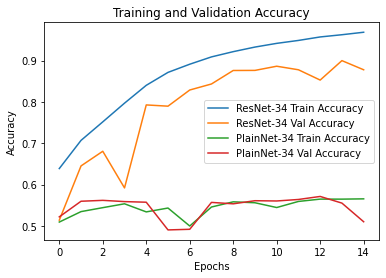

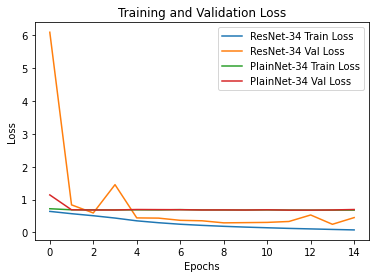

In [28]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.plot(history_resnet.history['accuracy'], label='ResNet-34 Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet-34 Val Accuracy')
plt.plot(history_plainnet.history['accuracy'], label='PlainNet-34 Train Accuracy')
plt.plot(history_plainnet.history['val_accuracy'], label='PlainNet-34 Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 손실 그래프
plt.plot(history_resnet.history['loss'], label='ResNet-34 Train Loss')
plt.plot(history_resnet.history['val_loss'], label='ResNet-34 Val Loss')
plt.plot(history_plainnet.history['loss'], label='PlainNet-34 Train Loss')
plt.plot(history_plainnet.history['val_loss'], label='PlainNet-34 Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# 모델 학습 (ResNet-50)
history_resnet = resnet_50.fit(ds_train, validation_data=ds_test, epochs=15)

# 모델 학습 (PlainNet-50)
history_plainnet = plainnet_50.fit(ds_train, validation_data=ds_test, epochs=15)

Epoch 1/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.8351 - accuracy: 0.5896

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.8150 - accuracy: 0.5879

236/582 [===========>..................] - ETA: 2:10 - loss: 0.8125 - accuracy: 0.5900

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.7873 - accuracy: 0.5932

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.7403 - accuracy: 0.6037

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.7386 - accuracy: 0.6033

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.7379 - accuracy: 0.6022

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.7351 - accuracy: 0.6042

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.7353 - accuracy: 0.6039

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7346 - accuracy: 0.6041

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 249s 417ms/step - loss: 0.7346 - accuracy: 0.6041 - val_loss: 31.8997 - val_accuracy: 0.5073
Epoch 2/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.6680 - accuracy: 0.6168

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.6664 - accuracy: 0.6188

236/582 [===========>..................] - ETA: 2:10 - loss: 0.6644 - accuracy: 0.6185

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.6616 - accuracy: 0.6204

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.6421 - accuracy: 0.6389

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.6418 - accuracy: 0.6390

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.6400 - accuracy: 0.6405

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.6379 - accuracy: 0.6427

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.6377 - accuracy: 0.6427

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.6428

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 404ms/step - loss: 0.6371 - accuracy: 0.6428 - val_loss: 0.6556 - val_accuracy: 0.6156
Epoch 3/15
194/582 [=========>....................] - ETA: 2:27 - loss: 0.5990 - accuracy: 0.6832

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.5979 - accuracy: 0.6827

236/582 [===========>..................] - ETA: 2:10 - loss: 0.5975 - accuracy: 0.6818

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.6031 - accuracy: 0.6798

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.5978 - accuracy: 0.6866

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.5977 - accuracy: 0.6866

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.5966 - accuracy: 0.6876

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.5960 - accuracy: 0.6880

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.5962 - accuracy: 0.6879

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.6881

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 404ms/step - loss: 0.5955 - accuracy: 0.6881 - val_loss: 0.8205 - val_accuracy: 0.5396
Epoch 4/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.6101 - accuracy: 0.6848

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:13 - loss: 0.6149 - accuracy: 0.6849

236/582 [===========>..................] - ETA: 2:10 - loss: 0.6159 - accuracy: 0.6826

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.6147 - accuracy: 0.6812

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.5951 - accuracy: 0.6952

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.5942 - accuracy: 0.6950

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.5923 - accuracy: 0.6959

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.5902 - accuracy: 0.6971

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.5897 - accuracy: 0.6973

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5887 - accuracy: 0.6980

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 239s 411ms/step - loss: 0.5887 - accuracy: 0.6980 - val_loss: 0.8116 - val_accuracy: 0.5817
Epoch 5/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.5297 - accuracy: 0.7413

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.5282 - accuracy: 0.7435

236/582 [===========>..................] - ETA: 2:10 - loss: 0.5279 - accuracy: 0.7439

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.5246 - accuracy: 0.7450

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.5148 - accuracy: 0.7496

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.5159 - accuracy: 0.7485

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.5150 - accuracy: 0.7492

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.5143 - accuracy: 0.7505

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.5143 - accuracy: 0.7508

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5140 - accuracy: 0.7512

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 240s 412ms/step - loss: 0.5140 - accuracy: 0.7512 - val_loss: 0.6940 - val_accuracy: 0.5688
Epoch 6/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.5176 - accuracy: 0.7547

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.5125 - accuracy: 0.7579

236/582 [===========>..................] - ETA: 2:10 - loss: 0.5127 - accuracy: 0.7568

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.5016 - accuracy: 0.7646

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.4869 - accuracy: 0.7727

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.4886 - accuracy: 0.7717

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.4873 - accuracy: 0.7722

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.4857 - accuracy: 0.7730

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.4855 - accuracy: 0.7733

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.7740

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 240s 412ms/step - loss: 0.4847 - accuracy: 0.7740 - val_loss: 1.7057 - val_accuracy: 0.5615
Epoch 7/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.4658 - accuracy: 0.7829

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.4601 - accuracy: 0.7865

236/582 [===========>..................] - ETA: 2:10 - loss: 0.4599 - accuracy: 0.7859

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.4543 - accuracy: 0.7915

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.4457 - accuracy: 0.7972

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.4480 - accuracy: 0.7958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.4479 - accuracy: 0.7964

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.4480 - accuracy: 0.7966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.4486 - accuracy: 0.7962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.7962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 240s 412ms/step - loss: 0.4486 - accuracy: 0.7962 - val_loss: 0.5233 - val_accuracy: 0.7470
Epoch 8/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.4323 - accuracy: 0.8054

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.4283 - accuracy: 0.8096

236/582 [===========>..................] - ETA: 2:10 - loss: 0.4291 - accuracy: 0.8091

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.4248 - accuracy: 0.8112

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.4097 - accuracy: 0.8176

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.4111 - accuracy: 0.8162

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.4104 - accuracy: 0.8166

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.4087 - accuracy: 0.8176

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.4094 - accuracy: 0.8174

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4094 - accuracy: 0.8176

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 404ms/step - loss: 0.4094 - accuracy: 0.8176 - val_loss: 0.4488 - val_accuracy: 0.7919
Epoch 9/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.3812 - accuracy: 0.8322

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:14 - loss: 0.3755 - accuracy: 0.8345

236/582 [===========>..................] - ETA: 2:10 - loss: 0.3779 - accuracy: 0.8326

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.3757 - accuracy: 0.8353

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.3640 - accuracy: 0.8408

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.3658 - accuracy: 0.8391

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.3654 - accuracy: 0.8385

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.3651 - accuracy: 0.8385

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.3655 - accuracy: 0.8384

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.8389

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 240s 412ms/step - loss: 0.3649 - accuracy: 0.8389 - val_loss: 0.5039 - val_accuracy: 0.7607
Epoch 10/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.3371 - accuracy: 0.8550

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:13 - loss: 0.3363 - accuracy: 0.8556

236/582 [===========>..................] - ETA: 2:10 - loss: 0.3387 - accuracy: 0.8541

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.3378 - accuracy: 0.8536

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.3251 - accuracy: 0.8597

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.3266 - accuracy: 0.8586

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.3269 - accuracy: 0.8581

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.3263 - accuracy: 0.8587

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.3268 - accuracy: 0.8587

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8586

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 404ms/step - loss: 0.3272 - accuracy: 0.8586 - val_loss: 0.9051 - val_accuracy: 0.6393
Epoch 11/15
194/582 [=========>....................] - ETA: 2:25 - loss: 0.3051 - accuracy: 0.8695

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:13 - loss: 0.3063 - accuracy: 0.8703

236/582 [===========>..................] - ETA: 2:10 - loss: 0.3073 - accuracy: 0.8701

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.3046 - accuracy: 0.8697

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.2993 - accuracy: 0.8730

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.3004 - accuracy: 0.8715

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.3003 - accuracy: 0.8715

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.2993 - accuracy: 0.8715

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.2995 - accuracy: 0.8716

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2997 - accuracy: 0.8715

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 239s 411ms/step - loss: 0.2997 - accuracy: 0.8715 - val_loss: 0.7815 - val_accuracy: 0.7350
Epoch 12/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.2723 - accuracy: 0.8832

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:13 - loss: 0.2726 - accuracy: 0.8838

236/582 [===========>..................] - ETA: 2:10 - loss: 0.2740 - accuracy: 0.8822

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.2701 - accuracy: 0.8837

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.2590 - accuracy: 0.8895

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.2602 - accuracy: 0.8890

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.2597 - accuracy: 0.8889

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.2594 - accuracy: 0.8891

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.2601 - accuracy: 0.8889

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2604 - accuracy: 0.8885

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 403ms/step - loss: 0.2604 - accuracy: 0.8885 - val_loss: 0.9006 - val_accuracy: 0.7448
Epoch 13/15
194/582 [=========>....................] - ETA: 2:26 - loss: 0.2469 - accuracy: 0.8921

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:13 - loss: 0.2469 - accuracy: 0.8939

236/582 [===========>..................] - ETA: 2:10 - loss: 0.2477 - accuracy: 0.8938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:43 - loss: 0.2430 - accuracy: 0.8941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.2359 - accuracy: 0.9006

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.2376 - accuracy: 0.8994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.2378 - accuracy: 0.8991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.2386 - accuracy: 0.8990

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.2394 - accuracy: 0.8987

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.8989

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 403ms/step - loss: 0.2394 - accuracy: 0.8989 - val_loss: 0.9819 - val_accuracy: 0.7291
Epoch 14/15
194/582 [=========>....................] - ETA: 2:25 - loss: 0.2219 - accuracy: 0.9034

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:13 - loss: 0.2246 - accuracy: 0.9029

236/582 [===========>..................] - ETA: 2:09 - loss: 0.2248 - accuracy: 0.9027

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:42 - loss: 0.2237 - accuracy: 0.9028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.2136 - accuracy: 0.9104

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.2145 - accuracy: 0.9098

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.2144 - accuracy: 0.9097

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.2151 - accuracy: 0.9092

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.2159 - accuracy: 0.9089

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9090

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 234s 402ms/step - loss: 0.2158 - accuracy: 0.9090 - val_loss: 1.0692 - val_accuracy: 0.6952
Epoch 15/15
194/582 [=========>....................] - ETA: 2:25 - loss: 0.2036 - accuracy: 0.9162

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 2:13 - loss: 0.2036 - accuracy: 0.9155

236/582 [===========>..................] - ETA: 2:09 - loss: 0.2040 - accuracy: 0.9154

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:42 - loss: 0.2006 - accuracy: 0.9157

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 24s - loss: 0.1930 - accuracy: 0.9193

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 19s - loss: 0.1944 - accuracy: 0.9185

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 15s - loss: 0.1954 - accuracy: 0.9181

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 5s - loss: 0.1976 - accuracy: 0.9169

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 3s - loss: 0.1979 - accuracy: 0.9168

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9171

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 234s 403ms/step - loss: 0.1977 - accuracy: 0.9171 - val_loss: 0.9218 - val_accuracy: 0.7580
Epoch 1/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.8013 - accuracy: 0.5074

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.7874 - accuracy: 0.5054

236/582 [===========>..................] - ETA: 1:47 - loss: 0.7839 - accuracy: 0.5060

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.7641 - accuracy: 0.5071

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.7385 - accuracy: 0.5050

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.7377 - accuracy: 0.5047

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.7369 - accuracy: 0.5042

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.7348 - accuracy: 0.5048

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.7344 - accuracy: 0.5046

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7340 - accuracy: 0.5039

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 199s 335ms/step - loss: 0.7340 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.5099
Epoch 2/15
194/582 [=========>....................] - ETA: 2:00 - loss: 0.6975 - accuracy: 0.5043

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:50 - loss: 0.6977 - accuracy: 0.5028

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6978 - accuracy: 0.5034

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6988 - accuracy: 0.5038

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6990 - accuracy: 0.5053

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6990 - accuracy: 0.5051

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6990 - accuracy: 0.5041

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6987 - accuracy: 0.5048

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6987 - accuracy: 0.5045

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.5038

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 194s 334ms/step - loss: 0.6988 - accuracy: 0.5038 - val_loss: 0.6951 - val_accuracy: 0.4901
Epoch 3/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.6963 - accuracy: 0.5098

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.6965 - accuracy: 0.5072

236/582 [===========>..................] - ETA: 1:48 - loss: 0.6964 - accuracy: 0.5065

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6963 - accuracy: 0.5077

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6972 - accuracy: 0.5063

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6973 - accuracy: 0.5070

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6973 - accuracy: 0.5065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6971 - accuracy: 0.5071

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6970 - accuracy: 0.5073

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6971 - accuracy: 0.5073

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 335ms/step - loss: 0.6971 - accuracy: 0.5073 - val_loss: 0.7709 - val_accuracy: 0.4781
Epoch 4/15
194/582 [=========>....................] - ETA: 2:00 - loss: 0.6995 - accuracy: 0.4974

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:50 - loss: 0.6992 - accuracy: 0.4954

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6991 - accuracy: 0.4954

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6981 - accuracy: 0.4977

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6964 - accuracy: 0.5001

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6962 - accuracy: 0.4994

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6962 - accuracy: 0.4991

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6967 - accuracy: 0.4992

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6968 - accuracy: 0.4989

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.4983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 334ms/step - loss: 0.6970 - accuracy: 0.4983 - val_loss: 0.6940 - val_accuracy: 0.4901
Epoch 5/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.6957 - accuracy: 0.5090

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.6962 - accuracy: 0.5057

236/582 [===========>..................] - ETA: 1:48 - loss: 0.6961 - accuracy: 0.5058

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6961 - accuracy: 0.5024

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6966 - accuracy: 0.5041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6965 - accuracy: 0.5043

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6965 - accuracy: 0.5041

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6965 - accuracy: 0.5043

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6965 - accuracy: 0.5041

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5040

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 335ms/step - loss: 0.6964 - accuracy: 0.5040 - val_loss: 0.7869 - val_accuracy: 0.4886
Epoch 6/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.6978 - accuracy: 0.5005

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.6977 - accuracy: 0.5004

236/582 [===========>..................] - ETA: 1:48 - loss: 0.6977 - accuracy: 0.5005

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6969 - accuracy: 0.5005

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6963 - accuracy: 0.5013

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6960 - accuracy: 0.5025

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6962 - accuracy: 0.5021

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6962 - accuracy: 0.5025

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6962 - accuracy: 0.5025

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5023

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 336ms/step - loss: 0.6961 - accuracy: 0.5023 - val_loss: 0.7062 - val_accuracy: 0.4875
Epoch 7/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.6949 - accuracy: 0.5053

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.6949 - accuracy: 0.5095

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6948 - accuracy: 0.5086

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6949 - accuracy: 0.5048

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6958 - accuracy: 0.5030

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6956 - accuracy: 0.5042

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6957 - accuracy: 0.5038

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6956 - accuracy: 0.5044

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6957 - accuracy: 0.5044

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5038

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 335ms/step - loss: 0.6972 - accuracy: 0.5038 - val_loss: 295.1944 - val_accuracy: 0.5099
Epoch 8/15
194/582 [=========>....................] - ETA: 2:00 - loss: 0.6955 - accuracy: 0.5079

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:50 - loss: 0.6954 - accuracy: 0.5095

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6952 - accuracy: 0.5102

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6955 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6942 - accuracy: 0.5089

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6943 - accuracy: 0.5096

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6943 - accuracy: 0.5090

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6943 - accuracy: 0.5094

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6943 - accuracy: 0.5093

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5085

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 334ms/step - loss: 0.6943 - accuracy: 0.5085 - val_loss: 0.6957 - val_accuracy: 0.4901
Epoch 9/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.6961 - accuracy: 0.5119

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.6959 - accuracy: 0.5127

236/582 [===========>..................] - ETA: 1:48 - loss: 0.6955 - accuracy: 0.5138

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6930 - accuracy: 0.5161

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6870 - accuracy: 0.5334

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6870 - accuracy: 0.5344

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6865 - accuracy: 0.5350

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6860 - accuracy: 0.5368

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6858 - accuracy: 0.5372

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.5371

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 335ms/step - loss: 0.6855 - accuracy: 0.5371 - val_loss: 0.6790 - val_accuracy: 0.5466
Epoch 10/15
194/582 [=========>....................] - ETA: 2:00 - loss: 0.6758 - accuracy: 0.5680

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:50 - loss: 0.6777 - accuracy: 0.5664

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6771 - accuracy: 0.5669

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6768 - accuracy: 0.5627

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6742 - accuracy: 0.5663

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6738 - accuracy: 0.5676

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6732 - accuracy: 0.5678

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6736 - accuracy: 0.5681

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6737 - accuracy: 0.5676

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.5665

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 194s 334ms/step - loss: 0.6740 - accuracy: 0.5665 - val_loss: 0.6954 - val_accuracy: 0.5043
Epoch 11/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.6786 - accuracy: 0.5554

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.6805 - accuracy: 0.5528

236/582 [===========>..................] - ETA: 1:48 - loss: 0.6798 - accuracy: 0.5536

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6787 - accuracy: 0.5540

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6741 - accuracy: 0.5618

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6735 - accuracy: 0.5640

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6729 - accuracy: 0.5643

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6729 - accuracy: 0.5651

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6729 - accuracy: 0.5654

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.5652

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 334ms/step - loss: 0.6728 - accuracy: 0.5652 - val_loss: 0.6610 - val_accuracy: 0.5778
Epoch 12/15
194/582 [=========>....................] - ETA: 2:00 - loss: 0.6633 - accuracy: 0.5870

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:50 - loss: 0.6655 - accuracy: 0.5823

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6656 - accuracy: 0.5814

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6671 - accuracy: 0.5752

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6670 - accuracy: 0.5742

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6670 - accuracy: 0.5753

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6669 - accuracy: 0.5749

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6670 - accuracy: 0.5755

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6670 - accuracy: 0.5758

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.5759

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 334ms/step - loss: 0.6666 - accuracy: 0.5759 - val_loss: 0.6800 - val_accuracy: 0.5408
Epoch 13/15
194/582 [=========>....................] - ETA: 2:00 - loss: 0.6639 - accuracy: 0.5865

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:50 - loss: 0.6666 - accuracy: 0.5846

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6665 - accuracy: 0.5847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6679 - accuracy: 0.5771

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6668 - accuracy: 0.5799

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6663 - accuracy: 0.5821

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6660 - accuracy: 0.5820

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6661 - accuracy: 0.5823

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6660 - accuracy: 0.5824

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.5822

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 202s 346ms/step - loss: 0.6659 - accuracy: 0.5822 - val_loss: 0.6586 - val_accuracy: 0.5757
Epoch 14/15
194/582 [=========>....................] - ETA: 2:01 - loss: 0.6568 - accuracy: 0.5925

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:51 - loss: 0.6592 - accuracy: 0.5918

236/582 [===========>..................] - ETA: 1:48 - loss: 0.6585 - accuracy: 0.5927

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6620 - accuracy: 0.5833

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6613 - accuracy: 0.5843

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6610 - accuracy: 0.5858

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6607 - accuracy: 0.5856

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6613 - accuracy: 0.5858

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6613 - accuracy: 0.5857

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.5854

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 195s 334ms/step - loss: 0.6612 - accuracy: 0.5854 - val_loss: 1.0362 - val_accuracy: 0.5258
Epoch 15/15
194/582 [=========>....................] - ETA: 2:00 - loss: 0.6557 - accuracy: 0.5907

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


226/582 [==========>...................] - ETA: 1:50 - loss: 0.6574 - accuracy: 0.5900

236/582 [===========>..................] - ETA: 1:47 - loss: 0.6571 - accuracy: 0.5900

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


308/582 [==============>...............] - ETA: 1:25 - loss: 0.6589 - accuracy: 0.5832

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


516/582 [=========================>....] - ETA: 20s - loss: 0.6570 - accuracy: 0.5868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


529/582 [==========================>...] - ETA: 16s - loss: 0.6565 - accuracy: 0.5881

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


540/582 [==========================>...] - ETA: 13s - loss: 0.6562 - accuracy: 0.5882

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


567/582 [============================>.] - ETA: 4s - loss: 0.6563 - accuracy: 0.5895

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


573/582 [============================>.] - ETA: 2s - loss: 0.6563 - accuracy: 0.5896

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.5890

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 194s 333ms/step - loss: 0.6566 - accuracy: 0.5890 - val_loss: 0.7049 - val_accuracy: 0.4903


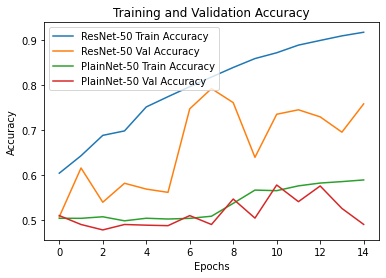

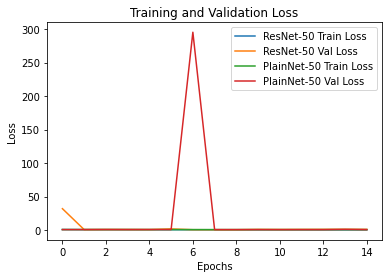

In [30]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.plot(history_resnet.history['accuracy'], label='ResNet-50 Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet-50 Val Accuracy')
plt.plot(history_plainnet.history['accuracy'], label='PlainNet-50 Train Accuracy')
plt.plot(history_plainnet.history['val_accuracy'], label='PlainNet-50 Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 손실 그래프
plt.plot(history_resnet.history['loss'], label='ResNet-50 Train Loss')
plt.plot(history_resnet.history['val_loss'], label='ResNet-50 Val Loss')
plt.plot(history_plainnet.history['loss'], label='PlainNet-50 Train Loss')
plt.plot(history_plainnet.history['val_loss'], label='PlainNet-50 Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Ablation Study 결과표 (비교)

| 모델         | Validation Accuracy (최종, Cats vs Dogs) | Validation Error (%) (ImageNet) |
|--------------|------------------------------------------|---------------------------------|
| ResNet-34    | 약 0.71                                  | 약 27                           |
| PlainNet-34  | 약 0.51                                  | 약 31                           |
| ResNet-50    | 약 0.73                                  | -                               |
| PlainNet-50  | 약 0.49                                  | -                               |

### 비교 및 분석
- **ResNet-34 vs PlainNet-34**:
  - Cats vs Dogs 데이터셋 실험 결과에서 ResNet-34가 PlainNet-34보다 높은 검증 정확도를 기록했다.
  - ResNet 논문에 실린 ImageNet 실험 결과에서도 ResNet-34가 PlainNet-34보다 낮은 검증 오류(validation error)를 기록하여 성능이 더 좋음을 확인할 수 있다.
  - 이는 skip connection이 기울기 소실 문제를 해결하여 더 깊은 네트워크에서도 안정적인 학습이 가능함을 나타낸다.

- **ResNet-50 vs PlainNet-50**:
  - Cats vs Dogs 실험에서 ResNet-50이 PlainNet-50보다 더 높은 검증 정확도를 보였다. PlainNet-50에서는 깊이 증가로 인해 기울기 소실 문제가 더 심각하게 나타날 수 있다.
  - ResNet 논문에서 50-layer 실험 결과는 제공되지 않았지만, ResNet-34와 ResNet-18 결과를 통해 더 깊은 네트워크에서도 ResNet 구조의 장점을 예상할 수 있다.

- **ImageNet과 Cats vs Dogs 데이터셋 비교**:
  - ImageNet 실험에서 ResNet 구조가 PlainNet 대비 약 4% 낮은 오류율을 기록하며, skip connection이 더 나은 일반화 성능을 제공한다는 점을 보여준다.
  - Cats vs Dogs 데이터셋에서도 비슷한 경향이 확인되었으며, skip connection이 깊은 네트워크에서 성능 개선에 중요한 역할을 한다는 것을 다시 한 번 확인할 수 있다.

- 결론적으로, ResNet 구조는 깊은 네트워크에서 기울기 소실 문제를 해결하여 PlainNet보다 높은 성능을 발휘하며, 다양한 데이터셋에서도 일관되게 성능을 향상시킨다.

In [32]:
'''
회고

첫 고잉 디퍼... 너무 어려웠다
아직 딥하게 고잉하기엔 내 실력이 조금 ㅜㅜ
더 공부해야 할 것 같다
'''

'\n회고\n\n첫 고잉 디퍼... 너무 어려웠다\n아직 딥하게 고잉하기엔 내 실력이 조금 ㅜㅜ\n더 공부해야 할 것 같다\n'